# Import pyspark library and other essential classes and functions.

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn')

### Initiate a SparkSession

In [3]:
spark = SparkSession.builder.appName("Congress").getOrCreate()

I observed the data format of file before loading it to spark.
#### Load CSV data into Spark dataframe

In [4]:
votes_read = spark.read.csv('./house-votes-84.data')

#### Inspect loaded data
<pre>
_c0. Class Name: 2 (democrat, republican)
_c1. handicapped-infants: 2 (y,n)
_c2. water-project-cost-sharing: 2 (y,n)
_c3. adoption-of-the-budget-resolution: 2 (y,n)
_c4. physician-fee-freeze: 2 (y,n)
_c5. el-salvador-aid: 2 (y,n)
_c6. religious-groups-in-schools: 2 (y,n)
_c7. anti-satellite-test-ban: 2 (y,n)
_c8. aid-to-nicaraguan-contras: 2 (y,n)
_c9. mx-missile: 2 (y,n)
_c10. immigration: 2 (y,n)
_c11. synfuels-corporation-cutback: 2 (y,n)
_c12. education-spending: 2 (y,n)
_c13. superfund-right-to-sue: 2 (y,n)
_c14. crime: 2 (y,n)
_c15. duty-free-exports: 2 (y,n)
_c16. export-administration-act-south-africa: 2 (y,n)
</pre>

In [5]:
votes_read.show()

+----------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+
|       _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|
+----------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+
|republican|  n|  y|  n|  y|  y|  y|  n|  n|  n|   y|   ?|   y|   y|   y|   n|   y|
|republican|  n|  y|  n|  y|  y|  y|  n|  n|  n|   n|   n|   y|   y|   y|   n|   ?|
|  democrat|  ?|  y|  y|  ?|  y|  y|  n|  n|  n|   n|   y|   n|   y|   y|   n|   n|
|  democrat|  n|  y|  y|  n|  ?|  y|  n|  n|  n|   n|   y|   n|   y|   n|   n|   y|
|  democrat|  y|  y|  y|  n|  y|  y|  n|  n|  n|   n|   y|   ?|   y|   y|   y|   y|
|  democrat|  n|  y|  y|  n|  y|  y|  n|  n|  n|   n|   n|   n|   y|   y|   y|   y|
|  democrat|  n|  y|  n|  y|  y|  y|  n|  n|  n|   n|   n|   n|   ?|   y|   y|   y|
|republican|  n|  y|  n|  y|  y|  y|  n|  n|  n|   n|   n|   n|   y|   y|   ?|   y|
|republican|  n|  y|  n|  y|  y|  y|  n|  n|  n|   n|   n|   y|   y|   y|   

The records do not have an unique attribute or key which can be used to identify each record while evaluating results, to tackle this issue I'll add a column to dataframe with increasing value

#### Add an unique index column to the dataframe

In [6]:
votes = votes_read.withColumn("id", monotonically_increasing_id())

#### See how many records the dataframe contain

In [7]:
votes.count()

435

#### Inspecting undetermined votes

In [8]:
votes.filter(votes['_c1']=='?').show()

+----------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+
|       _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16| id|
+----------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+
|  democrat|  ?|  y|  y|  ?|  y|  y|  n|  n|  n|   n|   y|   n|   y|   y|   n|   n|  2|
|  democrat|  ?|  ?|  ?|  ?|  n|  y|  y|  y|  y|   y|   ?|   n|   y|   y|   n|   ?|104|
|  democrat|  ?|  ?|  y|  n|  n|  n|  y|  y|  ?|   n|   ?|   ?|   ?|   ?|   ?|   ?|129|
|  democrat|  ?|  y|  n|  n|  n|  n|  y|  y|  y|   y|   y|   n|   n|   y|   y|   y|143|
|  democrat|  ?|  n|  y|  n|  n|  n|  y|  y|  y|   y|   y|   ?|   n|   n|   y|   ?|178|
|  democrat|  ?|  ?|  y|  n|  n|  n|  y|  y|  y|   ?|   ?|   n|   n|   n|   ?|   ?|180|
|  democrat|  ?|  ?|  ?|  ?|  ?|  ?|  ?|  ?|  y|   ?|   ?|   ?|   ?|   ?|   ?|   ?|183|
|republican|  ?|  ?|  ?|  ?|  ?|  ?|  ?|  ?|  ?|   ?|   ?|   ?|   ?|   ?|   ?|   ?|248|
|  democrat|  ?|  ?|  n|  n|  ?|

### Dealing with undetermined votes

**There are multiple ways undetermined values can be handled.**<br/><br/>
The method I prefer to handle '?' values is to replace these string values by null, and drop them using Spark SQL method to drop a record if it has a null value. I'm using simple map reduce functions to achieve this, because of its flexibility and code reusability.

**Import required functions -**<br/><br/>
*col* function allows to access column by its name.<br/>
*when* function allows to conditionally return a column object.<br/>
*reduce* is a reduce function from Python's standard library.<br/>

In [9]:
from pyspark.sql.functions import col, when
from functools import reduce

Define a function which takes column as argument, it returns a value for observation if it does not equal to '?'. Otherwise it will return Python None type, which will be interpreted as null in Spark dataframe.

In [10]:
def replacewNull(i):
    return when(col(i) != '?', col(i)).otherwise(None)

Here withColumn works as a mapper function which maps repalcewNull function to each column (we exclude the last column we added using list slicing) in the dataframe. We collect all modified columns using reduce function and store them into vote_null as a new dataframe

In [11]:
vote_null = reduce(lambda df, x: df.withColumn(x, replacewNull(x)), votes.columns[0:-1], votes)

Inspect if the values are replaced by null, we can refer to the unique ids we added to observations earlier.

In [12]:
vote_null.filter(votes['_c1']=='?').show()

+----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+
|       _c0| _c1| _c2| _c3| _c4| _c5| _c6| _c7| _c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16| id|
+----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+
|  democrat|null|   y|   y|null|   y|   y|   n|   n|   n|   n|   y|   n|   y|   y|   n|   n|  2|
|  democrat|null|null|null|null|   n|   y|   y|   y|   y|   y|null|   n|   y|   y|   n|null|104|
|  democrat|null|null|   y|   n|   n|   n|   y|   y|null|   n|null|null|null|null|null|null|129|
|  democrat|null|   y|   n|   n|   n|   n|   y|   y|   y|   y|   y|   n|   n|   y|   y|   y|143|
|  democrat|null|   n|   y|   n|   n|   n|   y|   y|   y|   y|   y|null|   n|   n|   y|null|178|
|  democrat|null|null|   y|   n|   n|   n|   y|   y|   y|null|null|   n|   n|   n|null|null|180|
|  democrat|null|null|null|null|null|null|null|null|   y|null|null|null|null|null|null|null|183|
|republican|null|null|null|nul

#### Drop the entire observation / record if any column has a null value

In [13]:
votes_cleaned = vote_null.na.drop(how='any')

#### Inspect the cleaned data

In [14]:
votes_cleaned.show()

+----------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+
|       _c0|_c1|_c2|_c3|_c4|_c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16| id|
+----------+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+---+
|  democrat|  n|  y|  y|  n|  y|  y|  n|  n|  n|   n|   n|   n|   y|   y|   y|   y|  5|
|republican|  n|  y|  n|  y|  y|  y|  n|  n|  n|   n|   n|   y|   y|   y|   n|   y|  8|
|  democrat|  y|  y|  y|  n|  n|  n|  y|  y|  y|   n|   y|   n|   n|   n|   y|   y| 19|
|  democrat|  y|  y|  y|  n|  n|  n|  y|  y|  y|   n|   n|   n|   n|   n|   y|   y| 23|
|  democrat|  y|  n|  y|  n|  n|  n|  y|  y|  y|   y|   n|   n|   n|   n|   y|   y| 25|
|  democrat|  y|  n|  y|  n|  n|  n|  y|  y|  y|   n|   y|   n|   n|   n|   y|   y| 26|
|  democrat|  y|  y|  y|  n|  n|  n|  y|  y|  y|   n|   y|   n|   n|   n|   y|   y| 27|
|republican|  y|  n|  n|  y|  y|  n|  y|  y|  y|   n|   n|   y|   y|   y|   n|   y| 28|
|  democrat|  y|  y|  y|  n|  n|

#### Records after removing records with missing values

In [15]:
votes_cleaned.count()

232

#### How many records are lost?

In [16]:
votes.count() - votes_cleaned.count()

203

#### What percentage of observations / records have missing values?

In [17]:
print("{0:.2f}%".format(100 - (votes_cleaned.count() * 100 / votes.count())))

46.67%


# K-means Clustering

Performing K-means clustering on data to group voters based on thier voting pattern.

Import essential classes and functions

In [18]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

Use string indexer to index the yea or nay votes to numbers

In [19]:
indexers = [StringIndexer(inputCol=column, outputCol=column+'_idx').fit(votes_cleaned) for column in votes.columns[1:-1]]

Use pipeline to process multiple string indexing operations at once

In [20]:
pipeline = Pipeline(stages=indexers)
votes_indexed = pipeline.fit(votes_cleaned).transform(votes_cleaned)

Use vector assembler to assemble vectors of indexed features

In [21]:
assembler = VectorAssembler(inputCols=['_c1_idx','_c2_idx','_c3_idx','_c4_idx','_c5_idx','_c6_idx','_c7_idx',
                                       '_c8_idx','_c9_idx','_c10_idx','_c11_idx','_c12_idx','_c13_idx','_c14_idx',
                                       '_c15_idx','_c16_idx'], outputCol='features')

Add assembled vector to dataframe

In [22]:
votes_prep = assembler.transform(votes_indexed)

### Estimating number of clusters

##### Testing with Elbow Method

In [23]:
costk = dict()
# This is a placeholder value for k=1, since PySpark doesn't accept K=1 for KMeans
costk[1] = 1000

In [24]:
for i in range(2,8):
    km = KMeans().setK(i)
    mdl = km.fit(votes_prep)
    costk[i] = mdl.computeCost(votes_prep)

In [25]:
costk

{1: 1000,
 2: 507.9103566376295,
 3: 464.56861130714327,
 4: 441.20693864597706,
 5: 415.0658237316876,
 6: 395.50653220752764,
 7: 385.21539806317276}

### Plotting the cost as K increases

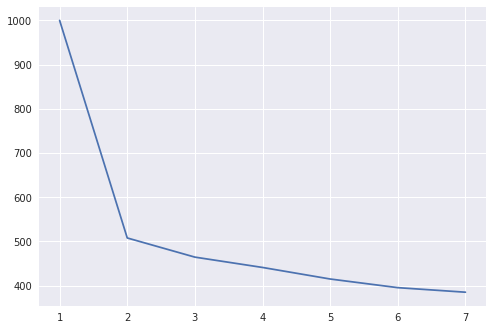

In [26]:
plt.plot(list(costk.keys()),list(costk.values()))

### Predicting party label using clustering

We set K = 2, since there are only two parties, and define the K-means model.

In [27]:
# Trains a k-means model.
kmeans = KMeans(k=2,featuresCol='features').setSeed(51)
model = kmeans.fit(votes_prep)

Next, we transform the dataframe by applying the k-means model to it so prediction column will be added to the dataframe. Then collect the projection of selected attributes in dataframe to a variable called *transformed*.

In [28]:
transformedT = model.transform(votes_prep).select("_c0","features", "prediction","id")

Inspect the dataframe with the results, where **_c0_idx** is the index of original label and **predicion** is the predicted cluster.

In [29]:
transformedT.show()

+----------+--------------------+----------+---+
|       _c0|            features|prediction| id|
+----------+--------------------+----------+---+
|  democrat|(16,[1,6,7,9,14],...|         1|  5|
|republican|(16,[1,2,3,6,7,9,...|         1|  8|
|  democrat|[1.0,1.0,0.0,0.0,...|         0| 19|
|  democrat|(16,[0,1,4,5,8,9,...|         0| 23|
|  democrat|(16,[0,4,5,8,12,1...|         0| 25|
|  democrat|(16,[0,4,5,8,9,10...|         0| 26|
|  democrat|[1.0,1.0,0.0,0.0,...|         0| 27|
|republican|(16,[0,2,3,5,8,9,...|         1| 28|
|  democrat|[1.0,1.0,0.0,0.0,...|         0| 29|
|republican|(16,[1,2,3,6,7,9,...|         1| 30|
|  democrat|(16,[0,1,4,5,8,13...|         0| 32|
|republican|(16,[1,2,3,6,7,9,...|         1| 33|
|  democrat|(16,[0,1,4,5,8,9,...|         0| 34|
|republican|(16,[1,2,3,6,7,9,...|         1| 35|
|republican|(16,[0,1,2,3,6,7,...|         1| 37|
|republican|(16,[1,2,3,6,7,11...|         1| 38|
|  democrat|(16,[0,4,5,8,10,1...|         0| 39|
|  democrat|(16,[0,4

In [30]:
def indexParty(i):
    return when(col(i) != 'democrat', 1).otherwise(0)

In [31]:
transformed = reduce(lambda df, x: df.withColumn(x, indexParty(x)), transformedT.columns[0:1], transformedT)

In [32]:
transformed.show()

+---+--------------------+----------+---+
|_c0|            features|prediction| id|
+---+--------------------+----------+---+
|  0|(16,[1,6,7,9,14],...|         1|  5|
|  1|(16,[1,2,3,6,7,9,...|         1|  8|
|  0|[1.0,1.0,0.0,0.0,...|         0| 19|
|  0|(16,[0,1,4,5,8,9,...|         0| 23|
|  0|(16,[0,4,5,8,12,1...|         0| 25|
|  0|(16,[0,4,5,8,9,10...|         0| 26|
|  0|[1.0,1.0,0.0,0.0,...|         0| 27|
|  1|(16,[0,2,3,5,8,9,...|         1| 28|
|  0|[1.0,1.0,0.0,0.0,...|         0| 29|
|  1|(16,[1,2,3,6,7,9,...|         1| 30|
|  0|(16,[0,1,4,5,8,13...|         0| 32|
|  1|(16,[1,2,3,6,7,9,...|         1| 33|
|  0|(16,[0,1,4,5,8,9,...|         0| 34|
|  1|(16,[1,2,3,6,7,9,...|         1| 35|
|  1|(16,[0,1,2,3,6,7,...|         1| 37|
|  1|(16,[1,2,3,6,7,11...|         1| 38|
|  0|(16,[0,4,5,8,10,1...|         0| 39|
|  0|(16,[0,4,5,8,9,12...|         0| 42|
|  0|(16,[0,4,5,8,9,12...|         0| 43|
|  0|(16,[0,1,4,5,8,9,...|         0| 46|
+---+--------------------+--------

### Evaluating classification performance
Since PySpark does not provide a evaluator, we can use metrics functions from scikit learn, given we prepare our data in required input format. (BinaryClassEvaluator cannot be used here)

**Some functions from scikit learn are required here.**
### pip install scikit-learn

In [33]:
from sklearn.metrics import roc_curve, auc

Convert the pyspark dataframe column in Python list, since it is the accepted input object for scikit learn functions

In [34]:
y_label = [int(i['_c0']) for i in transformed.collect()]
y_pred = [int(i['prediction']) for i in transformed.collect()]

Prepare dictionaries for SciKit roc function, as required.

In [35]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr[0], tpr[0], _ = roc_curve(y_pred, y_label)
roc_auc[0] = auc(fpr[0], tpr[0])

Prepare the plot for ROC curve

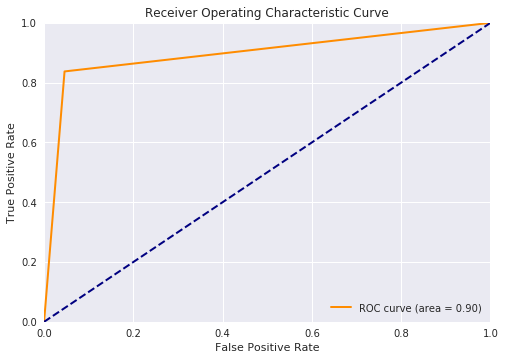

In [36]:
plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

#### Evaluate clustering by computing Within Set Sum of Squared Errors.


In [37]:
wssse = model.computeCost(transformed)
print("Within Set Sum of Squared Errors = " + str(wssse))

Within Set Sum of Squared Errors = 507.9409263817414


#### Inspect the centroids

In [38]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 0.63302752  0.42201835  0.09174312  0.04587156  0.94495413  0.67889908
  0.12844037  0.02752294  0.90825688  0.43119266  0.44954128  0.03669725
  0.80733945  0.73394495  0.66055046  0.00917431]
[ 0.2195122   0.49593496  0.80487805  0.87804878  0.00813008  0.07317073
  0.76422764  0.89430894  0.11382114  0.46341463  0.25203252  0.84552846
  0.13821138  0.02439024  0.11382114  0.34146341]


#### How to visualize clusters?
Issues:
1. The features are binary.
2. Dataset has high dimentionality.

Solutions:
1. Prepare Scatter plot matrix of votes on liberal vs conservative issues.
<br/>or
2. Reduce diamentions to two, possibly the diamentions which reflect liberal and conservative votes.

## Principle Component Analysis

Import PCA

In [39]:
from pyspark.ml.feature import PCA

Define PCA Model, for 2 principal components

In [40]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

Transform the dataframe using PCA model to get PCA features

In [41]:
pca_model = pca.fit(transformed)

Seperate dataframes based on party of a voter

In [42]:
pca_result = pca_model.transform(transformed).select('pcaFeatures','_c0','prediction').toPandas()

In [43]:
pca_result_D_label = pca_result.loc[pca_result['_c0'] ==  0]
pca_result_R_label = pca_result.loc[pca_result['_c0'] ==  1]

In [44]:
pcasR_label = pca_result_R_label['pcaFeatures'].tolist()
pcasD_label = pca_result_D_label['pcaFeatures'].tolist()

### Prepare Plot for Actual Party Label

In [45]:
xlD, ylD = zip(*pcasD_label)
xlR, ylR = zip(*pcasR_label)

In [46]:
scat_fig = plt.figure(0,figsize=(16, 12))

In [47]:
ax1 = scat_fig.add_subplot(221)
ax1.set_title("Actual Party Labels")
ax1.scatter(xlD,ylD,color=['blue'], label='Democrat')
ax1.scatter(xlR,ylR,color=['red'], label='Republican')
ax1.set_xlabel("PCA-1")
ax1.set_ylabel("PCA-2")
ax1.legend(loc='upper left')

### Prepare Plot for K-Means

Separate dataframes based on K-Means clustering

In [48]:
pca_pred_D_pred = pca_result.loc[pca_result['prediction'] ==  0]
pca_pred_R_pred = pca_result.loc[pca_result['prediction'] ==  1]
pca_pred_D_pred.count()

pcaFeatures    109
_c0            109
prediction     109
dtype: int64

In [49]:
pcasR_pred = pca_pred_R_pred['pcaFeatures'].tolist()
pcasD_pred = pca_pred_D_pred['pcaFeatures'].tolist()

In [50]:
xpD, ypD = zip(*pcasD_pred)
xpR, ypR = zip(*pcasR_pred)

In [51]:
ax2 = scat_fig.add_subplot(222)
ax2.set_title("K-Means Clusters")
ax2.scatter(xpD,ypD,color=['blue'], label='Liberal')
ax2.scatter(xpR,ypR,color=['red'], label='Conservative')
ax2.set_xlabel("PCA-1")
ax2.set_ylabel("PCA-2")
ax2.legend(loc='upper left')

#### Display Scatter Plots

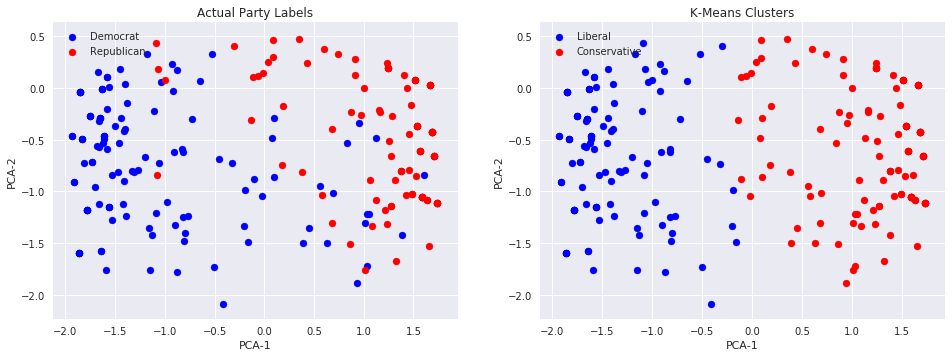

In [52]:
scat_fig

## Conclustion
Though K-Means can be used to predict the party of a voter with ~90% accuracy, The method is not perfect. K-Means is able to identify clusters on the bassis on political spectrum. (i.e. Conservative or Liberal). Not on the party basis.

Since we have the labels of party for each voter, we can tell which republicans are more moderate or liberal and which democrats are conservative based on thier voting patterns.

## Capturing a wider political spectrum
Clustering with 3 clusters, with intent being grouping moderate voters as a cluster.

In [53]:
# Trains a k-means model.
k3means = KMeans(k=3,featuresCol='features').setSeed(51)
model3 = k3means.fit(votes_prep)

In [54]:
transformedT3 = model3.transform(votes_prep).select("_c0","features", "prediction","id")

In [55]:
# PCA to reduce dimentions to two, in order to visualize
pca2 = PCA(k=2, inputCol="features", outputCol="pcaFeatures")

In [56]:
pca_model2 = pca2.fit(transformedT3)

In [57]:
pca_result2 = pca_model2.transform(transformedT3).select('pcaFeatures','_c0','prediction').toPandas()

Preparing lists of co-ordinates for scatter plot

In [58]:
pca_pred_1_pred = pca_result2.loc[pca_result2['prediction'] ==  0]
pca_pred_2_pred = pca_result2.loc[pca_result2['prediction'] ==  1]
pca_pred_3_pred = pca_result2.loc[pca_result2['prediction'] ==  2]

In [59]:
pcas1_pred = pca_pred_1_pred['pcaFeatures'].tolist()
pcas2_pred = pca_pred_2_pred['pcaFeatures'].tolist()
pcas3_pred = pca_pred_3_pred['pcaFeatures'].tolist()

In [60]:
xl1, yl1 = zip(*pcas1_pred)
xl2, yl2 = zip(*pcas2_pred)
xl3, yl3 = zip(*pcas3_pred)

Building the scatter plot

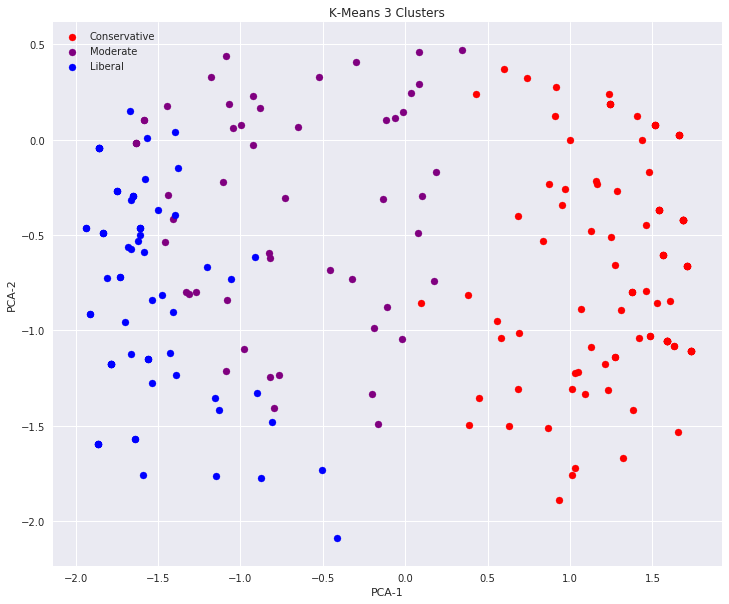

In [61]:
scat_fig2 = plt.figure(0,figsize=(12, 10))
axs3 = scat_fig2.add_subplot(111)
axs3.set_title("K-Means 3 Clusters")
axs3.scatter(xl1,yl1,color=["red"], label='Conservative')
axs3.scatter(xl2,yl2,color=["purple"], label='Moderate')
axs3.scatter(xl3,yl3,color=["blue"], label='Liberal')
axs3.set_xlabel("PCA-1")
axs3.set_ylabel("PCA-2")
axs3.legend(loc='upper left')